Removed no burn in
Removed no burn in
Removed no burn in


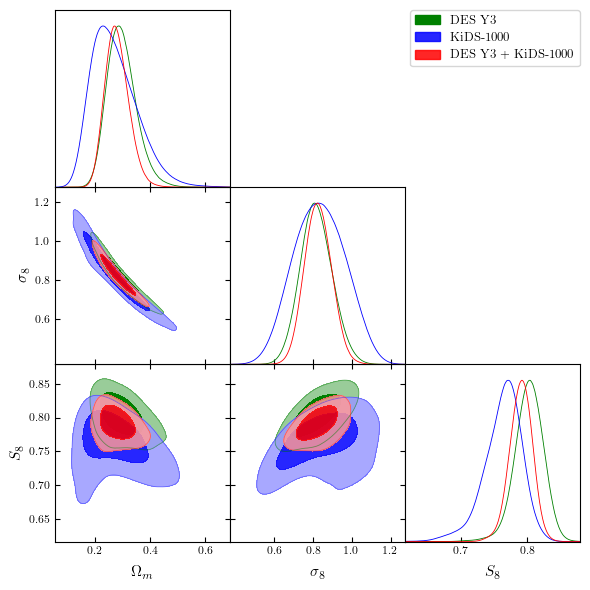

In [ ]:
import numpy as np
import matplotlib
from getdist import MCSamples, plots

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

def load_chain_with_weights(filename):
    data = np.loadtxt(filename)
    if filename == 'chain_desy3_hybrid_analysis.txt':
        samples = [data[:, 20], data[:, 18],data[:, 17]] # omegam, sigma8, S8
        weights = data[:, 31]
    elif filename == 'chain_kids1000_hybrid_analysis.txt':
        samples = [data[:, 17], data[:, 15],data[:, 14]] # omegam, sigma8, S8
        weights = data[:, 33]
    elif filename == 'chain_desy3_and_kids1000_hybrid_analysis.txt':
        samples = [data[:, 27], data[:, 25],data[:, 24]] # omegam, sigma8, S8
        weights = data[:, 50]
    return samples, weights

samples_des_arr, weights_des = load_chain_with_weights('chain_desy3_hybrid_analysis.txt')
samples_kids_arr, weights_kids = load_chain_with_weights('chain_kids1000_hybrid_analysis.txt')
samples_joint_arr, weights_joint = load_chain_with_weights('chain_desy3_and_kids1000_hybrid_analysis.txt')

names = ['omegam', 'sigma8', 'S_8']
labels = [r'\Omega_m', r'\sigma_8', r'S_8']

samples_des = MCSamples(samples=samples_des_arr, weights=weights_des, names=names, labels=labels, label='DES Y3')
samples_kids = MCSamples(samples=samples_kids_arr, weights=weights_kids, names=names, labels=labels, label='KiDS-1000')
samples_joint = MCSamples(samples=samples_joint_arr, weights=weights_joint, names=names, labels=labels, label='DES Y3 + KiDS-1000')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_des, samples_kids, samples_joint], ['omegam', 'sigma8', 'S_8'],
                filled=True, contour_colors=['green', 'blue', 'red'],
                legend_loc='upper right')